# Data Processing of the Tierpsy Tracker Results

Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [ ]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
import re


##Data Processing

Data Cleaning

In [ ]:
# Load the datasets and add the 'strain' column
timeseries_L1 = pd.read_csv('/content/drive/MyDrive/Worms/Data_Processing/Datasets/L1_timeseries_data.csv')
timeseries_L1['strain'] = 'L1'
timeseries_L2 = pd.read_csv('/content/drive/MyDrive/Worms/Data_Processing/Datasets/L2_timeseries_data.csv')
timeseries_L2['strain'] = 'L2'
timeseries_N2 = pd.read_csv('/content/drive/MyDrive/Worms/Data_Processing/Datasets/N2_timeseries_data.csv')
timeseries_N2['strain'] = 'N2'

# Combine the datasets

motility_features = pd.concat([timeseries_L1, timeseries_L2, timeseries_N2], ignore_index=True).copy()

print(f"Shape of the initial combined DataFrame: {motility_features.shape}")
print(motility_features.tail())

Shape of the initial combined DataFrame: (63669, 154)
       worm_index  timestamp well_name     speed  angular_velocity  \
63664         477        905    b'n/a'       NaN               NaN   
63665         477        906    b'n/a'  1.822590          0.041472   
63666         477        907    b'n/a'  2.055589          0.081443   
63667         477        908    b'n/a'       NaN               NaN   
63668         477        909    b'n/a'       NaN               NaN   

       relative_to_body_speed_midbody  \
63664                             NaN   
63665                             NaN   
63666                       -1.379909   
63667                             NaN   
63668                             NaN   

       relative_to_body_radial_velocity_head_tip  \
63664                                        NaN   
63665                                        NaN   
63666                                   5.341935   
63667                                        NaN   
63668             

In [ ]:
# Filter Worms with ≥245 Frames (10 seconds)
worm_frame_counts = motility_features['worm_index'].value_counts()
valid_worms = worm_frame_counts[worm_frame_counts >= 245].index
motility_features_filtered = motility_features[motility_features['worm_index'].isin(valid_worms)]

# Remove Non-Numeric Columns BEFORE Aggregation
columns_to_drop_early = [
    'timestamp', 'well_name', 'food_region',
    'dist_from_food_edge', 'orientation_food_edge'
]
motility_features_filtered = motility_features_filtered.drop(
    columns=columns_to_drop_early,
    errors='ignore'
)

# Select Only Numeric Columns for Aggregation
numeric_cols = motility_features_filtered.select_dtypes(include=['number']).columns.tolist()
grouping_cols = ['worm_index', 'strain']
motility_features_filtered_numeric = motility_features_filtered[grouping_cols + [col for col in numeric_cols if col not in grouping_cols]]

# Calculate Per-Worm Means of ABSOLUTE Values
motility_features_cleaned = (
    motility_features_filtered_numeric
    .groupby(grouping_cols)
    .agg(lambda x: x.abs().mean())
    .reset_index()
)

# Add "_mean" Suffix to Feature Columns
cols_to_rename = [col for col in motility_features_cleaned.columns if col not in grouping_cols]
motility_features_cleaned = motility_features_cleaned.rename(
    columns={col: f"{col}_mean" for col in cols_to_rename}
)

# Final Column Cleanup
final_columns_to_drop = [
    'worm_index', 'timestamp', 'well_name',
    'orientation_food_edge_mean', 'dist_from_food_edge_mean',
    'd_orientation_food_edge_mean', 'd_dist_from_food_edge_mean',
    'food_region', 'dist_from_food_edge', 'orientation_food_edge',
    'food_region_mean', 'd_dist_from_food_edge', 'd_orientation_food_edge',
    'd_minor_axis_mean','major_axis_mean', 'd_major_axis_mean', 'minor_axis_mean'
]
motility_features_cleaned = motility_features_cleaned.drop(
    columns=final_columns_to_drop,
    errors='ignore'
)

# Remove coordinate columns if present
coord_cols = [col for col in motility_features_cleaned.columns if 'coord' in col]
motility_features_cleaned = motility_features_cleaned.drop(columns=coord_cols, errors='ignore')

# Handle Missing Values

# 1. Drop columns that are ALL NaN
all_nan_cols = motility_features_cleaned.columns[motility_features_cleaned.isna().all()]
motility_features_cleaned = motility_features_cleaned.drop(columns=all_nan_cols)

# 2. Impute remaining NaNs with column means
numeric_cols_final = motility_features_cleaned.select_dtypes(include='number').columns.tolist()
motility_features_cleaned[numeric_cols_final] = motility_features_cleaned[numeric_cols_final].fillna(
    motility_features_cleaned[numeric_cols_final].mean()
)

# Validate and Output
print("\nFinal cleaned data columns:", motility_features_cleaned.columns.tolist())
print("Missing values:", motility_features_cleaned.isna().sum().sum())  # Should now be 0
print("\nSample data:")

print(motility_features_cleaned.head())
# --- Save Results ---
output_dir = '/content/drive/MyDrive/Worms/Data_Processing/Processed_Data'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'motility_features_cleaned.csv')
motility_features_cleaned.to_csv(output_path, index=False)

print(f"\nAnalysis complete. Results saved to {output_path}")
print("Final results preview:")
print(motility_features_cleaned.head())


Final cleaned data columns: ['strain', 'speed_mean', 'angular_velocity_mean', 'relative_to_body_speed_midbody_mean', 'relative_to_body_radial_velocity_head_tip_mean', 'relative_to_body_angular_velocity_head_tip_mean', 'relative_to_body_radial_velocity_neck_mean', 'relative_to_body_angular_velocity_neck_mean', 'relative_to_body_radial_velocity_hips_mean', 'relative_to_body_angular_velocity_hips_mean', 'relative_to_body_radial_velocity_tail_tip_mean', 'relative_to_body_angular_velocity_tail_tip_mean', 'speed_neck_mean', 'angular_velocity_neck_mean', 'relative_to_neck_radial_velocity_head_tip_mean', 'relative_to_neck_angular_velocity_head_tip_mean', 'speed_head_base_mean', 'angular_velocity_head_base_mean', 'relative_to_head_base_radial_velocity_head_tip_mean', 'relative_to_head_base_angular_velocity_head_tip_mean', 'speed_hips_mean', 'angular_velocity_hips_mean', 'relative_to_hips_radial_velocity_tail_tip_mean', 'relative_to_hips_angular_velocity_tail_tip_mean', 'speed_tail_base_mean', 

In [ ]:
motility_features_cleaned

,strain,speed_mean,angular_velocity_mean,relative_to_body_speed_midbody_mean,relative_to_body_radial_velocity_head_tip_mean,relative_to_body_angular_velocity_head_tip_mean,relative_to_body_radial_velocity_neck_mean,relative_to_body_angular_velocity_neck_mean,relative_to_body_radial_velocity_hips_mean,relative_to_body_angular_velocity_hips_mean,...,d_curvature_std_midbody_mean,d_curvature_std_hips_mean,d_curvature_std_tail_mean,d_path_curvature_body_mean,d_path_curvature_tail_mean,d_path_curvature_midbody_mean,d_path_curvature_head_mean,motion_mode_mean,turn_mean,head_tail_distance_mean
0,L1,17.048084,0.269103,2.070716,4.805491,0.434859,1.988731,0.231509,1.985512,0.196136,...,0.049091,0.068522,0.075221,0.000371,0.001649,0.000374,0.001225,0.898058,0.000000,54.102115
1,L2,17.048084,0.269103,2.070716,4.805491,0.434859,1.988731,0.231509,1.985512,0.196136,...,0.049091,0.068522,0.075221,0.000371,0.001649,0.000374,0.001225,0.898058,0.000000,54.102115
2,N2,17.048084,0.269103,2.070716,4.805491,0.434859,1.988731,0.231509,1.985512,0.196136,...,0.049091,0.068522,0.075221,0.000371,0.001649,0.000374,0.001225,0.898058,0.000000,54.102115
3,L1,12.367444,0.260341,2.701704,5.254833,0.369193,2.066430,0.237509,2.075431,0.249718,...,0.057897,0.073165,0.080141,0.401403,0.231687,0.185790,1.143944,0.963303,0.384615,52.736064
4,L2,12.367444,0.260341,2.701704,5.254833,0.369193,2.066430,0.237509,2.075431,0.249718,...,0.057897,0.073165,0.080141,0.401403,0.231687,0.185790,1.143944,0.963303,0.384615,52.736064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,L2,8.723601,0.176645,1.994774,3.816218,0.382049,1.560779,0.205580,1.159346,0.181441,...,0.041730,0.050513,0.072981,0.401403,0.231687,0.185790,1.143944,0.970000,0.000000,51.444741
227,N2,8.723601,0.176645,1.994774,3.816218,0.382049,1.560779,0.205580,1.159346,0.181441,...,0.041730,0.050513,0.072981,0.401403,0.231687,0.185790,1.143944,0.970000,0.000000,51.444741
228,L1,8.811279,0.173211,2.264392,5.730100,0.440883,1.545739,0.196735,1.300481,0.224325,...,0.040453,0.048425,0.047579,0.401403,0.231687,0.185790,1.143944,1.000000,0.000000,52.026527
229,L2,8.811279,0.173211,2.264392,5.730100,0.440883,1.545739,0.196735,1.300481,0.224325,...,0.040453,0.048425,0.047579,0.401403,0.231687,0.185790,1.143944,1.000000,0.000000,52.026527


In [ ]:
# Display the percentage of missing values for each column
print("\nPercentage of missing values per column:")
print((motility_features_cleaned.isna().sum() / len(motility_features_filtered)) * 100)


Percentage of missing values per column:
strain                                            0.0
speed_mean                                        0.0
angular_velocity_mean                             0.0
relative_to_body_speed_midbody_mean               0.0
relative_to_body_radial_velocity_head_tip_mean    0.0
                                                 ... 
d_path_curvature_midbody_mean                     0.0
d_path_curvature_head_mean                        0.0
motion_mode_mean                                  0.0
turn_mean                                         0.0
head_tail_distance_mean                           0.0
Length: 134, dtype: float64


Format for statistical analysis

In [300]:
# DataFrame
mf_df = motility_features_cleaned.copy()

# Verify essential columns exist
assert 'strain' in mf_df.columns, "'strain' column missing in input data"

# --- Column Metadata Parsing Setup ---
body_parts_suffixes = {
    'whole_worm': ['_whole_worm_mean', '_body_mean', '_mean','angular_velocity'],
    'head': ['_head_mean', '_head_tip_mean', '_head_base_mean','_head_base','_head_tip'],
    'neck': ['_neck_mean'],
    'midbody': ['_midbody_mean'],
    'hips': ['_hips_mean'],
    'tail': ['_tail_mean', '_tail_tip_mean', '_tail_base_mean']
}

measurement_types_base_keywords = {
    'speed': 'speed',
    'angular_velocity': 'angular_velocity',
    'length': 'morphology_size',
    'area': 'morphology_size',
    'quirkiness': 'morphology_posture',
    'head_tail_distance': 'morphology_size',
    'path_curvature': 'directionality',
    'eigen_projection': 'eigenworm',
    'width': 'morphology_size',
    'radial_velocity': 'radial_velocity',
    'motion_mode': 'directionality',
    'turn': 'directionality',
    'curvature': 'directionality'
}

def parse_column_metadata(original_col_name):
    """Parse Tierpsy feature names into standardized metadata"""
    measurement_type = 'base'
    measurement_class = 'unknown'
    body_part = 'unknown'
    working_name = original_col_name

    # Determine measurement type
    if working_name.startswith('d_'):
        measurement_type = 'differential'
        working_name = working_name[2:]

    # Find body part via suffix matching
    suffix_list = []
    for bp_key, suffixes in body_parts_suffixes.items():
        for suffix in suffixes:
            suffix_list.append((suffix, bp_key))
    suffix_list.sort(key=lambda x: (-len(x[0]), x[0]))  # Longest first

    for suffix, bp_key in suffix_list:
        if working_name.endswith(suffix):
            body_part = bp_key
            break

    if body_part == 'unknown' and working_name.endswith('_mean'):
        body_part = 'whole_worm'

    # Find measurement class
    sorted_mc_keywords = sorted(measurement_types_base_keywords.keys(),
                               key=len, reverse=True)
    for kw in sorted_mc_keywords:
        if re.search(r'(^|_)' + re.escape(kw) + r'(_|$)', working_name):
            measurement_class = measurement_types_base_keywords[kw]
            break

    # Special cases
    if original_col_name.startswith('eigen_projection_'):
        measurement_class = 'eigenworm'
        body_part = 'whole_worm'
    elif 'path_curvature_body_mean' == original_col_name:
        measurement_class = 'directionality'
        body_part = 'whole_worm'

    return {
        'measurement_type': measurement_type,
        'measurement_class': measurement_class,
        'body_part': body_part,
        'parameter': original_col_name
    }

# --- Feature Selection ---
exclude_cols = ['strain']
features_to_analyze = [
    col for col in mf_df.columns
    if col not in exclude_cols
    and pd.api.types.is_numeric_dtype(mf_df[col])
]

print(f"Analyzing {len(features_to_analyze)} features")
print(f"First 5 features: {features_to_analyze[:5]}")

# --- Statistical Analysis ---
# --- 2. Iterate through each parameter and fit an OLS model ---
all_ols_tidy_results = []
valid_tests = 0  # Track number of valid hypothesis tests

for param in features_to_analyze:
    try:
        temp_df = mf_df[[param, 'strain']].dropna()

        # Skip invalid features
        if temp_df[param].var() < 1e-6:
            print(f"Skipped {param}: zero variance")
            continue
        if len(temp_df['strain'].unique()) < 2:
            print(f"Skipped {param}: only one strain present")
            continue

        # Fit model
        model_formula = f"{param} ~ C(strain, Treatment('N2'))"
        model = smf.ols(model_formula, data=temp_df)
        result = model.fit()

        parsed_meta = parse_column_metadata(param)

        # Extract strain terms
        for term in result.model.exog_names:
            if term.startswith("C(strain, Treatment('N2'))[T."):
                strain = term.split('[T.')[1].split(']')[0]
                valid_tests += 1  # Count for Bonferroni

                all_ols_tidy_results.append({
                    **parsed_meta,
                    'term': strain,
                    'estimate': result.params[term],
                    'std.error': result.bse[term],
                    'statistic': result.tvalues[term],
                    'df': result.df_resid,
                    'p.value': result.pvalues[term]
                })

    except Exception as e:
        print(f"Skipped {param}: {str(e)}")

# --- 4. P-value Adjustment (Bonferroni) ---
statistical_results_df = pd.DataFrame(all_ols_tidy_results)

if not statistical_results_df.empty:
    # Calculate Bonferroni threshold based on ACTUAL number of tests
    n_comparisons = valid_tests
    print(f"Total valid comparisons: {n_comparisons}")

    reject, pvals_corrected, _, _ = multipletests(
        statistical_results_df['p.value'],
        alpha=0.05,
        method='bonferroni'
    )

    statistical_results_df['p_adj_bonferroni'] = pvals_corrected
    statistical_results_df['is_significant_adj'] = reject

    # Sort results
    statistical_results_df = statistical_results_df.sort_values(
        by=['is_significant_adj', 'p_adj_bonferroni'],
        ascending=[False, True]
    )
# --- Save Results ---
output_dir = '/content/drive/MyDrive/Worms/Data_Processing/Processed_Data'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'statistical_results_df.csv')
statistical_results_df.to_csv(output_path, index=False)

print(f"\nAnalysis complete. Results saved to {output_path}")
print("Final results preview:")
print(statistical_results_df.head())

Analyzing 133 features
First 5 features: ['speed_mean', 'angular_velocity_mean', 'relative_to_body_speed_midbody_mean', 'relative_to_body_radial_velocity_head_tip_mean', 'relative_to_body_angular_velocity_head_tip_mean']
Total valid comparisons: 266

Analysis complete. Results saved to /content/drive/MyDrive/Worms/Data_Processing/Processed_Data/statistical_results_df.csv
Final results preview:
  measurement_type measurement_class   body_part  \
0             base             speed  whole_worm   
1             base             speed  whole_worm   
2             base  angular_velocity  whole_worm   
3             base  angular_velocity  whole_worm   
4             base             speed     midbody   

                             parameter term      estimate  std.error  \
0                           speed_mean   L1  5.000000e+00   0.832843   
1                           speed_mean   L2 -1.337433e-15   0.832843   
2                angular_velocity_mean   L1 -3.826907e-17   0.012929   
3 

Whole-Worm Motility Features: Strain Differences (Bonferroni-Adjusted)

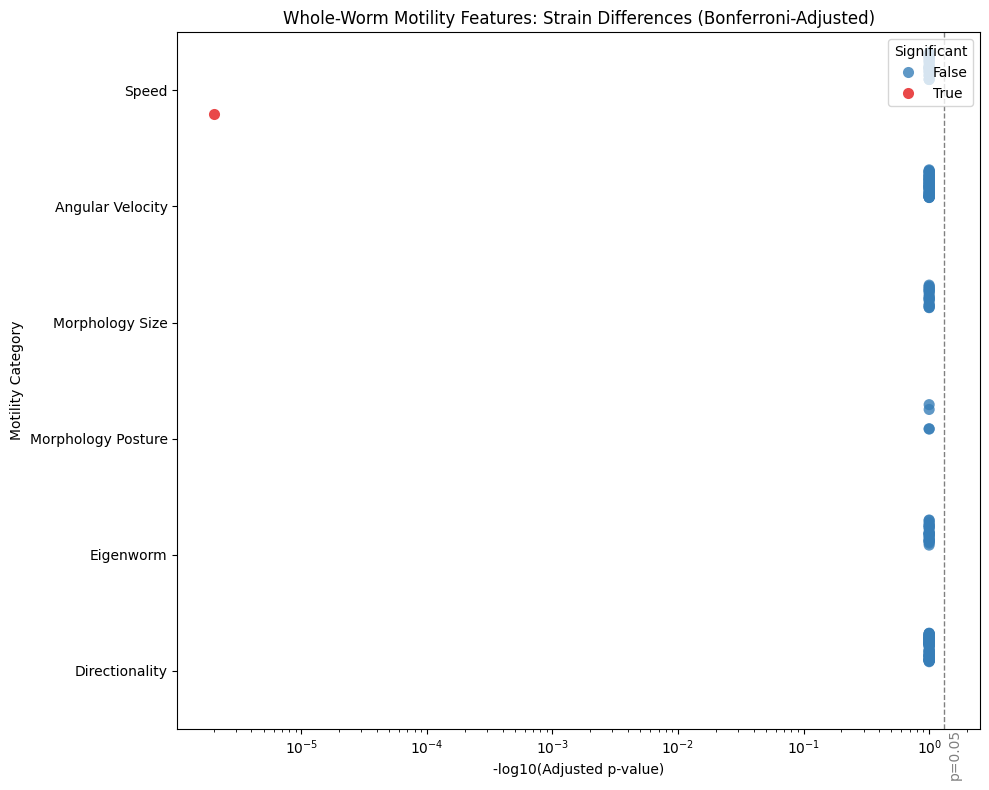

In [304]:
# Prepare data for plotting
plot_df = statistical_results_df.copy()

# Map features to motility categories using your existing metadata parser
plot_df['category'] = plot_df['parameter'].apply(
    lambda x: parse_column_metadata(x)['measurement_class']
)

# Clean up category names for display
category_map = {
    'angular_velocity': 'Angular Velocity',
    'directionality': 'Directionality',
    'eigenworm': 'Eigenworm',
    'morphology_posture': 'Morphology Posture',
    'morphology_size': 'Morphology Size',
    'speed': 'Speed'
}
plot_df['category'] = plot_df['category'].map(category_map)

# Create figure with multiple panels
plt.figure(figsize=(10, 8))

# Create stripplot with jitter
ax = sns.stripplot(
    data=plot_df,
    x='p_adj_bonferroni',
    y='category',
    hue='is_significant_adj',
    palette={True: '#e41a1c', False: '#377eb8'},
    dodge=True,
    jitter=0.25,
    size=8,
    alpha=0.8
)

# Add significance threshold line
plt.axvline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1)
plt.text(-np.log10(0.05)+0.1, 5.5, 'p=0.05', rotation=90, va='top', color='gray')

# Style the plot
plt.xscale('log')
plt.xlabel('-log10(Adjusted p-value)')
plt.ylabel('Motility Category')
plt.title('Whole-Worm Motility Features: Strain Differences (Bonferroni-Adjusted)')
plt.legend(title='Significant', loc='upper right')

# Add annotation for the significant result
if plot_df['is_significant_adj'].any():
    sig_row = plot_df[plot_df['is_significant_adj']].iloc[0]
    plt.annotate(
        'Speed (L1 vs N2)',
        xy=(-np.log10(sig_row['p_adj_bonferroni']),
            list(category_map.values()).index(sig_row['category'])),
        xytext=(-10, 20),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='black'),
        fontsize=10
    )

plt.tight_layout()
plt.show()

Speed_mean by Strain

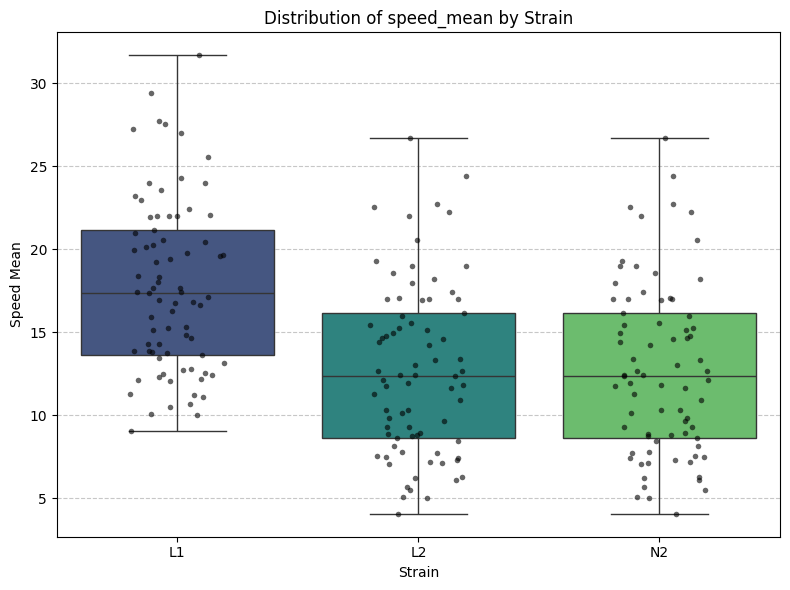

In [279]:
# Visualize "Speed_mean" with Boxplot and Individual Points ---
mf_df = pd.DataFrame(motility_features_cleaned)
mean_speed_col = 'speed_mean'

if mean_speed_col in mf_df.columns:
    plt.figure(figsize=(8, 6))

    # Create boxplot
    ax = sns.boxplot(
        data=mf_df,
        x='strain',
        y=mean_speed_col,
        hue='strain',  # Assign 'x' variable to 'hue'
        palette='viridis',
        showfliers=False,
        legend=False,  # Set legend to False
    )

    sns.stripplot(
        data=mf_df,
        x='strain',
        y=mean_speed_col,
        color='black',
        jitter=0.2,
        alpha=0.6,
        size=4
    )

    plt.title(f'Distribution of {mean_speed_col} by Strain')
    plt.xlabel('Strain')
    plt.ylabel(mean_speed_col.replace('_', ' ').title())
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"'{mean_speed_col}' not found in mf_df. Skipping boxplot visualization.")

Phenotypic Comparison

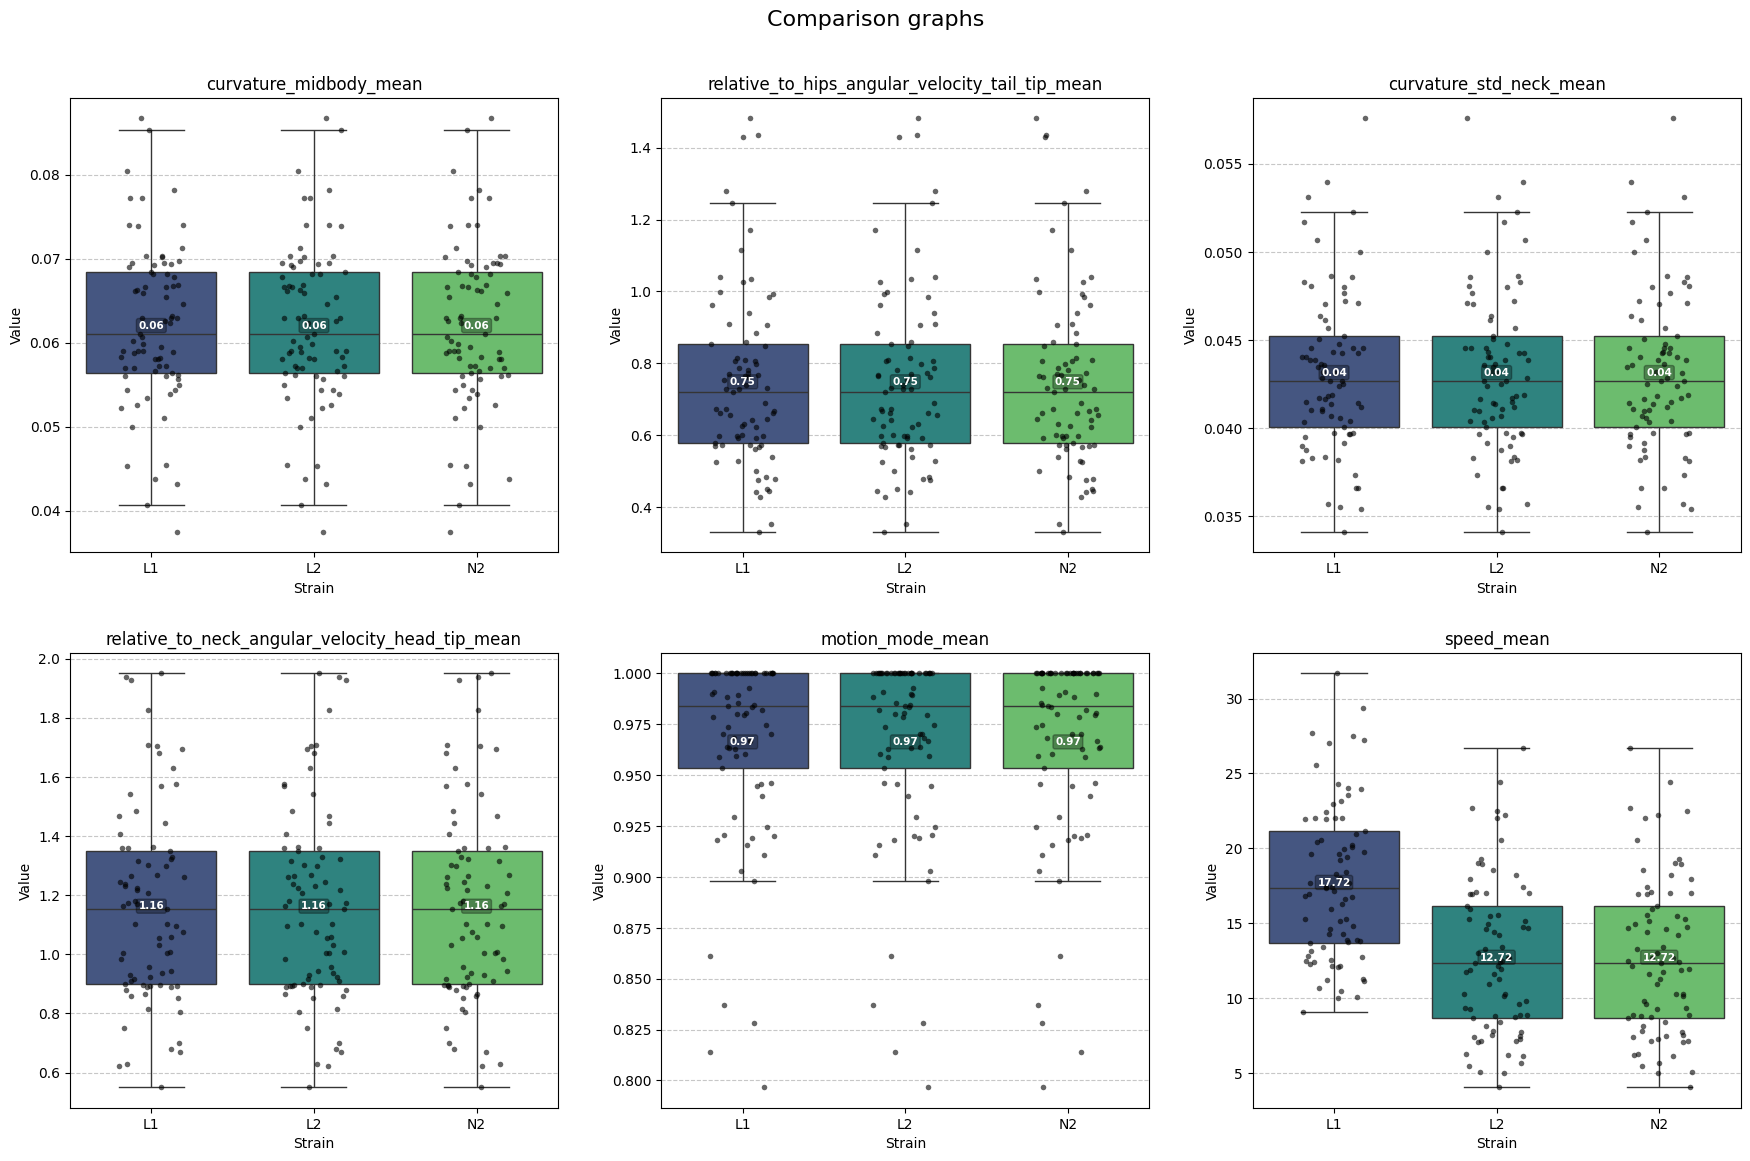

In [280]:
# DataFrame
mf_df = pd.DataFrame(motility_features_cleaned)

# Define features in desired order
features = [
    'curvature_midbody_mean',
    'relative_to_hips_angular_velocity_tail_tip_mean',
    'curvature_std_neck_mean',
    'relative_to_neck_angular_velocity_head_tip_mean',
    'motion_mode_mean',
    'speed_mean'
]

# Create figure with 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
plt.suptitle('Comparison graphs', fontsize=16, y=0.98)

def plot_feature(ax, feature):
    """Plot individual feature with formatting"""
    try:
        # Create plots
        sns.boxplot(data=mf_df, x='strain', y=feature,
                    hue='strain', palette='viridis',
                    showfliers=False, ax=ax, dodge=False)
        sns.stripplot(data=mf_df, x='strain', y=feature,
                      color='black', jitter=0.2,
                      size=4, alpha=0.6, ax=ax)

        # Calculate and annotate means
        means = mf_df.groupby('strain')[feature].mean()
        for i, (strain, mean_val) in enumerate(means.items()):
            ax.text(i, mean_val, f"{mean_val:.2f}",
                    ha='center', va='center', fontsize=7.5, color='white',
                    fontweight='semibold',
                    bbox=dict(facecolor='black', alpha=0.3, boxstyle='round,pad=0.2'))




        # Formatting
        ax.set_title(feature)
        ax.set_xlabel('Strain')
        ax.set_ylabel('Value')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    except KeyError:
        ax.axis('off')

# Plot all features in grid
for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    plot_feature(axs[row, col], feature)

plt.tight_layout(pad=2.5)
plt.show()


Heatmaps

1. Heatmap of Motility Features by Strain

Detected parameter columns: ['angular_velocity_head_base_mean', 'angular_velocity_head_tip_mean', 'angular_velocity_hips_mean', 'angular_velocity_mean', 'angular_velocity_midbody_mean', 'angular_velocity_neck_mean', 'angular_velocity_tail_base_mean', 'angular_velocity_tail_tip_mean', 'area_mean', 'curvature_head_mean', 'curvature_hips_mean', 'curvature_mean_head_mean', 'curvature_mean_hips_mean', 'curvature_mean_midbody_mean', 'curvature_mean_neck_mean', 'curvature_mean_tail_mean', 'curvature_midbody_mean', 'curvature_neck_mean', 'curvature_std_head_mean', 'curvature_std_hips_mean', 'curvature_std_midbody_mean', 'curvature_std_neck_mean', 'curvature_std_tail_mean', 'curvature_tail_mean', 'd_angular_velocity_head_base_mean', 'd_angular_velocity_head_tip_mean', 'd_angular_velocity_hips_mean', 'd_angular_velocity_mean', 'd_angular_velocity_midbody_mean', 'd_angular_velocity_neck_mean', 'd_angular_velocity_tail_base_mean', 'd_angular_velocity_tail_tip_mean', 'd_area_mean', 'd_curvature_hea

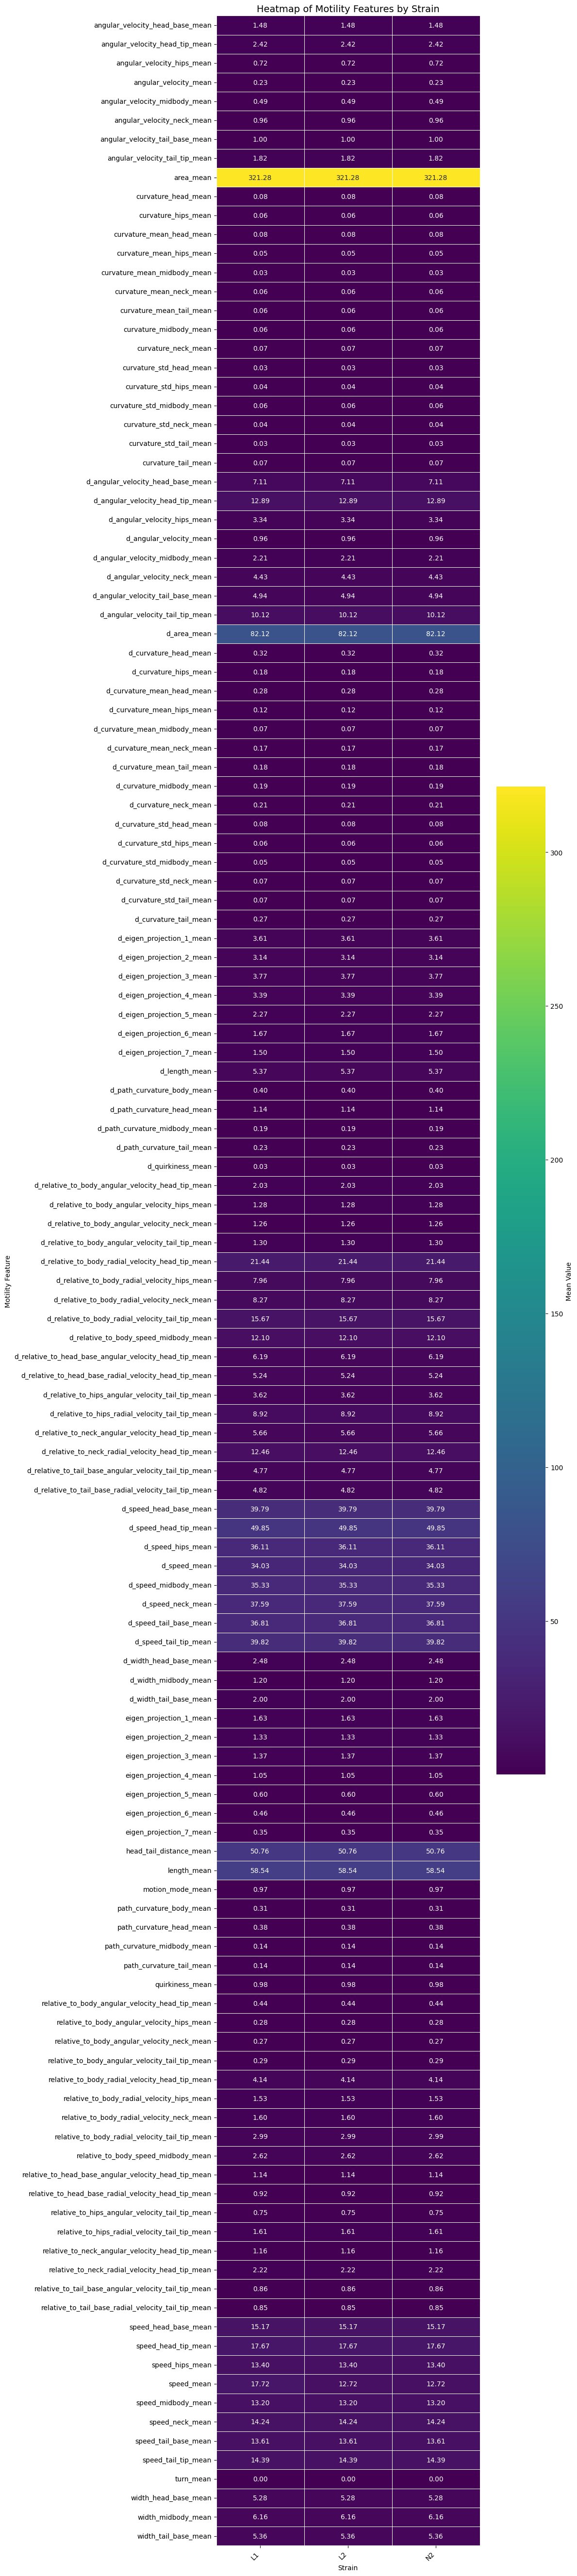

In [281]:
# DataFrame
mf_df = pd.DataFrame(motility_features_cleaned)

# Automatically identify the strain column and parameter columns ---
strain_column_name = 'strain'

# Automatically get all other columns as parameters
parameter_columns = motility_features_cleaned.columns.difference([strain_column_name])

print(f"Detected parameter columns: {parameter_columns.tolist()}\n")

# Melt the DataFrame to long format ---
df_long_format = motility_features_cleaned.melt(
    id_vars=[strain_column_name],
    value_vars=parameter_columns,
    var_name='Parameter',
    value_name='Value'
)

# Pivot to heatmap-ready format ---
df_heatmap_ready = df_long_format.pivot_table(
    index='Parameter',
    columns=strain_column_name,
    values='Value',
    aggfunc='mean'
)

# Optional: Sort rows for better visual grouping
df_heatmap_ready = df_heatmap_ready.sort_index()

# Plot the Heatmap ---
plt.figure(figsize=(12, max(6, 0.4 * len(df_heatmap_ready))))  # auto-adjust height

sns.heatmap(
    df_heatmap_ready,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    linewidths=0.4,
    cbar_kws={'label': 'Mean Value'}
)

plt.title('Heatmap of Motility Features by Strain', fontsize=14)
plt.xlabel('Strain')
plt.ylabel('Motility Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


2. Heatmap of Parameters excluding Strains & Correlation Heatmap Between Parameters

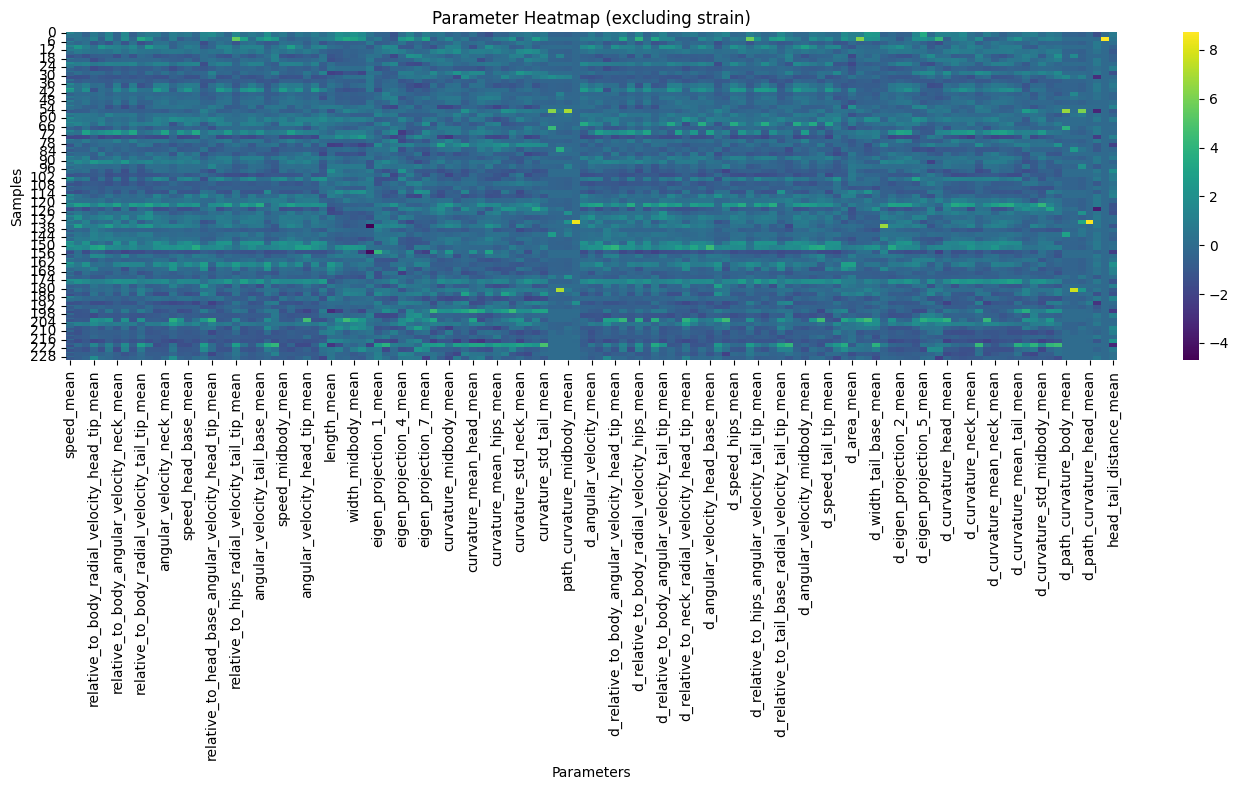

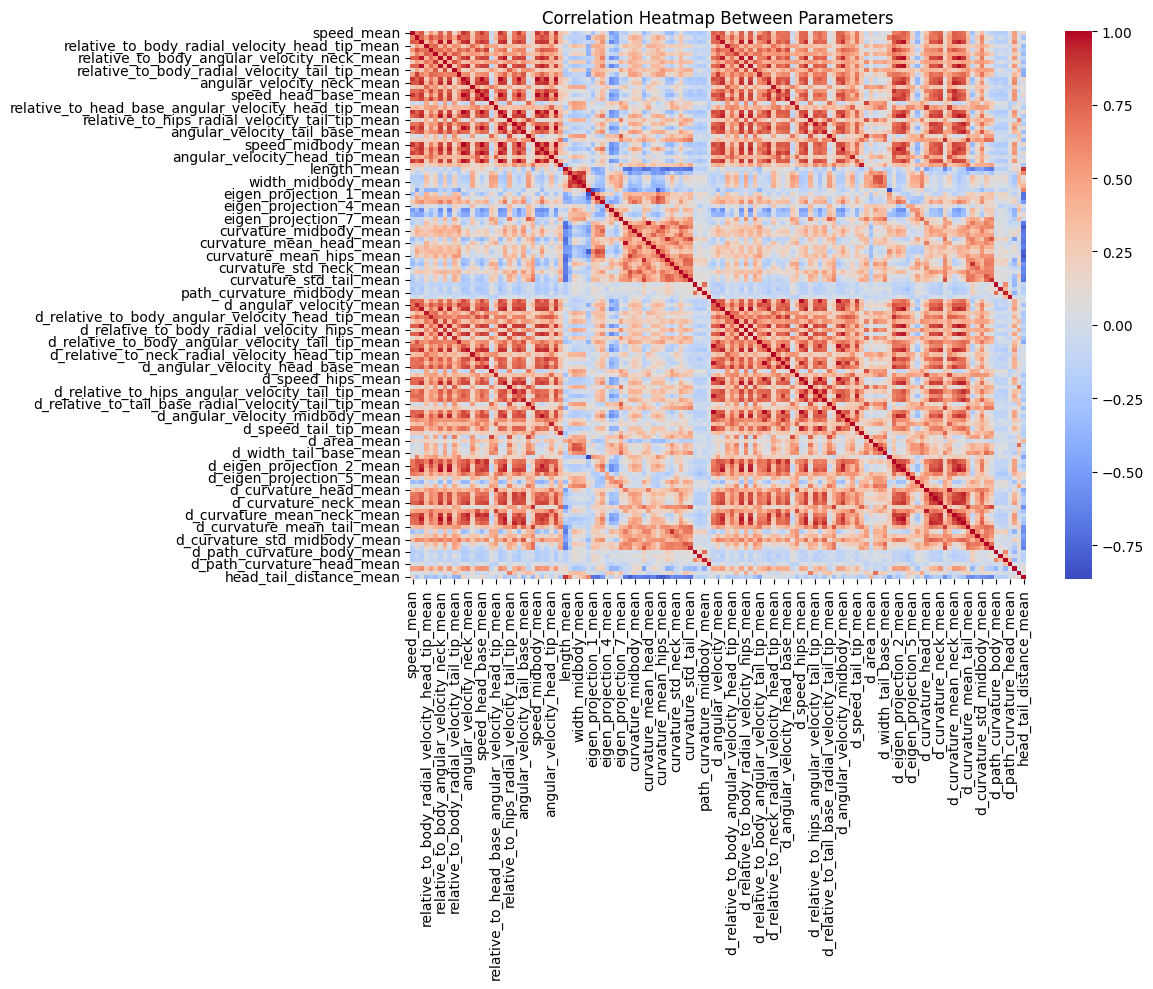

In [289]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Step 1: Load your CSV ---
mf_df = pd.DataFrame(motility_features_cleaned)

# --- Step 2: Separate label column ---
label_column = 'strain'
features = mf_df.drop(columns=[label_column])  # Everything except 'strain'

# --- Step 3: Encode categorical variables ---
features_encoded = pd.get_dummies(features)

# --- Step 4: Normalize the data ---
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_encoded), columns=features_encoded.columns)

# --- Step 5: Plot general heatmap (samples vs parameters) ---
plt.figure(figsize=(14, 8))
sns.heatmap(features_scaled, cmap='viridis', cbar=True)
plt.title('Parameter Heatmap (excluding strain)')
plt.xlabel('Parameters')
plt.ylabel('Samples')
plt.tight_layout()
plt.show()

# --- Step 6: (Optional) Correlation heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(features_scaled.corr(), annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap Between Parameters")
plt.tight_layout()
plt.show()


Mean values - Summary

In [298]:
# DataFrame
mf_df = pd.DataFrame(motility_features_cleaned)

# Assuming 'mf_df' is your original clean DataFrame with many parameters and 'strain' as a column
# Step 1: Melt the DataFrame into long format
df_melted = mf_df.melt(id_vars='strain', var_name='parameter', value_name='value')

# Step 2: Calculate the mean per strain and parameter
mean_values = df_melted.groupby(['strain', 'parameter'])['value'].mean().reset_index()

# --- Save Results ---
output_dir = '/content/drive/MyDrive/Worms/Data_Processing/Processed_Data'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'mean_values.csv')
mean_values.to_csv(output_path, index=False)

print("Mean values:")
mean_values


Mean values:


,strain,parameter,value
0,L1,angular_velocity_head_base_mean,1.478860
1,L1,angular_velocity_head_tip_mean,2.420892
2,L1,angular_velocity_hips_mean,0.724791
3,L1,angular_velocity_mean,0.227802
4,L1,angular_velocity_midbody_mean,0.492701
...,...,...,...
394,N2,speed_tail_tip_mean,14.394034
395,N2,turn_mean,0.004995
396,N2,width_head_base_mean,5.283813
397,N2,width_midbody_mean,6.161212


Environment information

In [ ]:
print("--- Python Version ---")
import sys
print(sys.version)

print("\n--- System Information ---")
!uname -a
!lsb_release -a # This works on Colab's Linux environment

print("\n--- GPU Information ---")
!nvidia-smi # Check if a GPU is allocated

print("\n--- Installed Python Packages (Partial List) ---")
!pip freeze # This lists all installed packages

print("\n--- Versions of Key Libraries Used ---")
import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib as mpl
import h5py
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Statsmodels: {statsmodels.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Matplotlib: {mpl.__version__}")
print(f"h5py: {h5py.__version__}")

--- Python Version ---
3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]

--- System Information ---
Linux fa33d95abe91 6.1.123+ #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy

--- GPU Information ---
/bin/bash: line 1: nvidia-smi: command not found

--- Installed Python Packages (Partial List) ---
absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.2
astropy-iers-data==0.2025.5.12.0.38.29
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto